# **Research Project (Honours)**

###### *By Mahlatsi Malise Mashilo (202215639)*

### **Forecasting Car Sales in South Africa Using Google Search Data with Post-hoc Explainable AI**

This project aims to forecast national monthly car sales in South Africa (who: automotive industry stakeholders) by integrating historical vehicle sales data with behavioral signals from Google Trends search indices (what). Using data spanning from 2010 Jan to 2025 Jan (when) and focusing on the South African automotive market (where), the study addresses why traditional forecasting methods—based only on past sales—often fail to capture rapid shifts in consumer interest and external market changes. To overcome this, the research compares traditional time-series models (SARIMA, LSSVR) with deep learning models (LSTM, CNN-LSTM, BiLSTM), both with and without online search data, to evaluate the added predictive value of behavioral signals (how). Finally, the best-performing deep learning models are interpreted using SHAP analysis to reveal which features most influence forecasts, supporting more data-driven, transparent, and responsive decision-making for manufacturers, dealerships, and analysts.

#### **Datasets:**

<table style="width:100%">
  <thead>
    <tr>
      <th>Name</th>
      <th>Start Date</th>
      <th>End Date</th>
      <th>Source</th>
      <th>Description</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>Motor Trade Sales.xlsx</td>
      <td>01-1998</td>
      <td>05-2025</td>
      <td>CEIC Data</td>
      <td>Revenue generated each month from sales</td>
    </tr>
    <tr>
      <td>Motor Vehicle Sales Monthly South Africa.xlsx</td>
      <td>01-2003</td>
      <td>06-2025</td>
      <td>CEIC Data</td>
      <td>Number of units sold each month</td>
    </tr>
    <tr>
      <td>Autos_Vehicles_Category.csv</td>
      <td>01-2004</td>
      <td>07-2025</td>
      <td>Google Trends</td>
      <td>The overall interest in the Autos Vehicles category on Google Trends</td>
    </tr>
    <tr>
      <td>Queries_Rising.csv</td>
      <td>01-2004</td>
      <td>07-2025</td>
      <td>Google Trends</td>
      <td>The currently rising queries related to the automotive category in Google Trends</td>
    </tr>
    <tr>
      <td>Queries_Top.csv</td>
      <td>01-2004</td>
      <td>07-2025</td>
      <td>Google Trends</td>
      <td>The currently top queries related to the automotive category in Google Trends</td>
    </tr>
    <tr>
      <td>Topic_Rising.csv</td>
      <td>01-2004</td>
      <td>07-2025</td>
      <td>Google Trends</td>
      <td>The currently rising topics related to the automotive category in Google Trends</td>
    </tr>
    <tr>
      <td>Topic_Top.csv</td>
      <td>01-2004</td>
      <td>07-2025</td>
      <td>Google Trends</td>
      <td>The currently top topics related to the automotive category in Google Trends</td>
    </tr>
  </tbody>
</table>


##### **Important Descriptions**
+ Interest over time from Google Trends:

    *Numbers represent search interest relative to the highest point on the chart for the given region and time. A value of 100 is the peak popularity for the term. A value of 50 means that the term is half as popular. A score of 0 means that there was not enough data for this term.*

## 1. Libraries

In [ ]:
# ! pip install pandas numpy matplotlib scikit-learn seaborn plotly statsmodels shap joblib openpyxl

In [2]:
import pandas as pd, numpy as np, seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt, seaborn as sns, plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os, joblib
import openpyxl
import tensorflow as tf
import keras
from pathlib import Path

# Deep learning
from keras.models import Sequential
from keras.layers import LSTM, Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Bidirectional
from keras.callbacks import EarlyStopping

# SARIMA, LSSVR
import statsmodels.api as sm
from sklearn.svm import SVR

## 2. Importing datasets

In [29]:
sales = pd.read_excel("Motor Trade Sales.xlsx", sheet_name="My Series")

vol = pd.read_excel("Motor Vehicle Sales Monthly South Africa.xlsx",  sheet_name="My Series")

In [30]:
print(sales.info())
print("="*50)
print(vol.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 329 entries, 0 to 328
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    329 non-null    datetime64[ns]
 1   Sales   329 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 5.3 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    270 non-null    datetime64[ns]
 1   Volume  270 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 4.3 KB
None


In [31]:
# Google trends data preperation
def load_and_merge_google_trends_data(folder_path):
    merged_df = None
    folder = Path(folder_path)
    
    for file in folder.glob("*.csv"):
        keyword = file.stem  # Get filename without extension
        df = pd.read_csv(file, skiprows=2)
        
        # Rename the value column using the keyword (assumes 2 columns: Month + keyword)
        if df.shape[1] > 1:
            df.columns = ['Month', keyword]
        else:
            continue  # skip malformed file

        # Merge into final dataset
        if merged_df is None:
            merged_df = df
        else:
            merged_df = pd.merge(merged_df, df, on='Month', how='outer')

    # Optional: sort by Month
    if merged_df is not None:
        merged_df.sort_values('Month', inplace=True)
    
    return merged_df


# Example usage:
base_path = "./GoogleTrends"
output_dir = "./Processed_Trends"
os.makedirs(output_dir, exist_ok=True)

folders = {
    "queries_rising": os.path.join(base_path, "Queries", "Rising"),
    "queries_top": os.path.join(base_path, "Queries", "Top"),
    "topics_rising": os.path.join(base_path, "Topics", "Rising"),
    "topics_top": os.path.join(base_path, "Topics", "Top")
}

# Process and save
for name, path in folders.items():
    merged = load_and_merge_google_trends_data(path)
    if merged is not None:
        merged.to_csv(os.path.join(output_dir, f"{name}.csv"), index=False)
        print(f"Saved: {name}.csv")
    else:
        print(f"No data found for: {name}")

Saved: queries_rising.csv
Saved: queries_top.csv
Saved: topics_rising.csv
Saved: topics_top.csv


## 3. Data Preparation

   1. We will limit the range of observation to 01-2004 to 05-2025, since that is where they all overlap. (This will act as a form of balancing the datasets)
   2. Make sure the "Date" column is in datetime format, and is the index of the dataframe.
   3. Shift the days to the last of the month

In [ ]:
def limit_date_range(df, date_column):
    # Replace "<1" values (strings) with 0 across all columns
    df.replace("<1", 0, inplace=True)
    # Convert to datetime
    df[date_column] = pd.to_datetime(df[date_column], errors='coerce', format='%Y-%m')
    # Shift dates to end of month
    df[date_column] = df[date_column].dt.to_period('M').dt.to_timestamp('M')
    # Define boundaries
    start_date = pd.to_datetime('2004-01')
    end_date = pd.to_datetime('2025-05')
    # Filter by date range
    df = df[(df[date_column] >= start_date) & (df[date_column] <= end_date)]
    return df


sales = limit_date_range(sales, 'Date')
vol = limit_date_range(vol, 'Date')

# Path to the folder
folder_path = "./Processed_Trends"
os.makedirs(folder_path, exist_ok=True)

# Apply filter to all CSVs in folder
for file in Path(folder_path).glob("*.csv"):
    try:
        df = pd.read_csv(file)
        # Rename 'Month' column to 'Date'
        if 'Month' in df.columns:
            df.rename(columns={'Month': 'Date'}, inplace=True)
        # Limit date range
        df_filtered = limit_date_range(df, 'Date')
        
        # Save the filtered dataframe
        out_file = Path(folder_path) / file.name
        df_filtered.to_csv(out_file, index=False)
        print(f"Filtered and saved: {out_file.name}")
    except Exception as e:
        print(f"Failed to process {file.name}: {e}")

Filtered and saved: queries_rising.csv
Filtered and saved: queries_top.csv
Filtered and saved: topics_rising.csv
Filtered and saved: topics_top.csv


In [34]:
# Here will will set the index of sales and vol dataframes to 'Date'
sales.set_index("Date", inplace=True)
vol.set_index("Date", inplace=True)

## 4. Data Understanding

### a. Time Series Plots

#### (i) Sales and Volume Time Series Plots

In [40]:
# Combine both series into one DataFrame
combined_df = pd.concat([
    sales.rename(columns={sales.columns[0]: 'Sales (Rmn)'}),
    vol.rename(columns={vol.columns[0]: 'Volume'})
], axis=1)

# Reset index to get date as a column
combined_df = combined_df.reset_index().rename(columns={'index': 'Date'})

# Melt to long format for seaborn lineplot
long_df = combined_df.melt(id_vars='Date', value_vars=['Sales (Rmn)', 'Volume'], 
                           var_name='Type', value_name='Value')

# Create interactive Plotly line chart
fig = px.line(
    long_df,
    x='Date',
    y='Value',
    color='Type',
    title='Sales and Volume Over Time',
    labels={'Value': 'Value/Count', 'Date': 'Date', 'Type': 'Legend'}
)

# Optional: Style tweaks
fig.update_layout(
    template='plotly_white',
    legend_title_text='Type',
    xaxis_title='Date',
    yaxis_title='Value/Count'
)

# Show the plot
fig.show()


##### *Interpretation:*

The graph shows an overall increase in sales (in millions) over the year with the volume of vehicles sold remaining in the 20-60 thousand range. In the early 2000's the volume of vehicles sold was more than the money generated, and it started maintaing the same trend up until 2016. After this the industry started focusing on maximizing profit. 

In early 2020, there was a sharp decline in both sales and volume. This was caused by the shut down of the country due to the Covid-19 Pandemic.[https://www.cars.co.za/motoring-news/new-car-sales-in-sa-march-2020/77385/]

#### (ii) Google Trends Time Series Plots

In [44]:
# Path to the folder
folder_path = "./Processed_Trends"
os.makedirs(folder_path, exist_ok=True)

# Apply filter and plot all CSVs
for file in Path(folder_path).glob("*.csv"):
    try:
        # Load the CSV and parse the index as datetime
        df = pd.read_csv(file, index_col=0, parse_dates=True)

        # Reset index to make 'Date' a column for Plotly
        df_reset = df.reset_index().rename(columns={df.index.name: 'Date'})

        # Melt to long format
        df_melted = df_reset.melt(id_vars='Date', var_name='Keyword', value_name='Interest')

        # Plot with Plotly
        fig = px.line(
            df_melted,
            x='Date',
            y='Interest',
            color='Keyword',
            title=f"{file.stem} Trends",
            labels={'Interest': 'Interest Level', 'Date': 'Date', 'Keyword': 'Keyword'}
        )

        fig.update_layout(
            template='plotly_white',
            legend_title_text='Keyword',
            xaxis_title='Date',
            yaxis_title='Interest Level'
        )

        fig.show()

    except Exception as e:
        print(f"Failed to plot {file.name}: {e}")

##### *Interpretation:*

So far all the graphs for the Google trends data is nonsensical, we will have to dig deeper at a later stage to extract some information from them.

### b. STL Plots for Sales and Volume

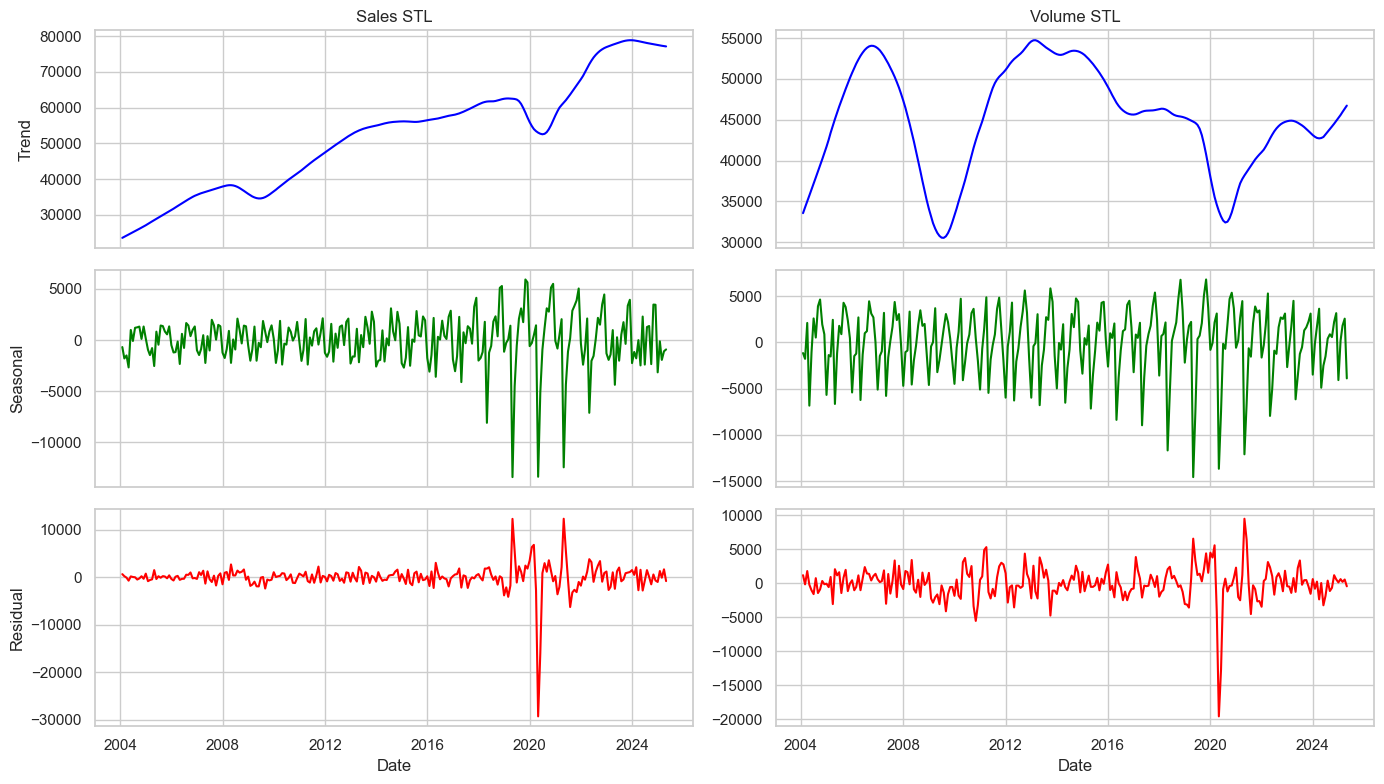

In [45]:
# Perform STL decomposition
stl_sales = STL(sales['Sales'], period=12).fit()
stl_vol = STL(vol['Volume'], period=12).fit()

# Create side-by-side subplots
fig, axes = plt.subplots(3, 2, figsize=(14, 8), sharex=True)

# Titles for each subplot column
axes[0, 0].set_title('Sales STL')
axes[0, 1].set_title('Volume STL')

# Plot Trend
axes[0, 0].plot(stl_sales.trend, label='Trend', color='blue')
axes[0, 1].plot(stl_vol.trend, label='Trend', color='blue')

# Plot Seasonal
axes[1, 0].plot(stl_sales.seasonal, label='Seasonal', color='green')
axes[1, 1].plot(stl_vol.seasonal, label='Seasonal', color='green')

# Plot Residual
axes[2, 0].plot(stl_sales.resid, label='Residual', color='red')
axes[2, 1].plot(stl_vol.resid, label='Residual', color='red')

# Y-axis labels
axes[0, 0].set_ylabel('Trend')
axes[1, 0].set_ylabel('Seasonal')
axes[2, 0].set_ylabel('Residual')

# X-axis label on bottom row
axes[2, 0].set_xlabel('Date')
axes[2, 1].set_xlabel('Date')

# Tight layout
plt.tight_layout()
plt.show()


##### **Intepretation:**
##### *Trend - Shows us the longterm movement of the sales*
+ From 2010-2014 there was a steady upward trend then from 2014-2018 it slowsdown and flattens with a minor dip between 2016-2018
+ In 2020 there was a sharp dip in the trend due to the Covid-19 Pandemic, where it only started to recover at the start of 2022

#### *Seasonality - shows us the repeating yearly patterns*
+ There are Consistent peaks and dips that follow a regular yearly rhythm.

#### *Residual - shows what's left after removing the trend and seasonality*
+ The residual is mostly well contained around y = 0 (i.e. sales = 0) but except at the 2020 crisis.
+ This suggest that noise is reasonably low and stable which indicates a well-behaved time series.

In [ ]:
stl = STL(sales['Sales'], period=12)
result = stl.fit()
result.plot()
plt.show()

In [13]:
vol

,Volume
Date,
2004-01-31,33601
2004-02-29,32338
2004-03-31,38892
2004-04-30,28681
2004-05-31,34347
...,...
2024-12-31,41273
2025-01-31,46398
2025-02-28,47978


In [45]:
import plotly.io as pio

pio.renderers.default = 'notebook'  # Force browser display

In [26]:
qt = pd.read_csv("./Processed_Trends/queries_top.csv")

qt

,audi,autotrader,bmw,car,cars,cars_for_sale,ford,honda,hyundai,kia,mercedes,mercedes_benz,nissan,opel,polo,suzuki,toyota,vw,webuycars
0,42,22,63,76,71,0,29,71,26,0,54,0,77,70,0,56,45,49,0
1,53,22,56,79,83,0,33,74,23,0,57,0,52,70,15,34,42,58,0
2,45,18,59,76,66,0,39,53,25,0,53,100,64,69,0,37,44,52,0
3,37,24,51,64,68,0,30,60,0,0,42,0,37,58,17,38,46,47,0
4,37,18,55,75,79,0,31,59,17,0,54,0,38,48,10,83,48,44,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,51,29,48,64,73,37,49,27,63,59,56,30,60,29,71,44,78,48,67
252,49,36,48,61,77,40,51,29,65,57,56,29,62,29,71,45,86,49,73
253,47,32,44,58,72,39,49,26,67,56,50,28,58,29,62,43,79,47,66
254,49,33,45,59,69,38,51,26,65,57,54,29,57,26,65,41,79,47,63


In [ ]:
# Plot with seaborn
plt.figure(figsize=(12, 6))
sns.lineplot(data=qt, x='Month', y='Value', hue='Type')

# Customize plot
plt.title('Sales and Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Value/Count')
plt.legend(title='Legend')
plt.tight_layout()

# Show the plot
plt.show()